In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hawkes Processes

## 1st method: Ogata

On va prendre une intensité initiale lambda = 1, et on ajoute e^(s-t) à chaque évènement

In [2]:
Tmax = 20
Lambda_init = 1

J'essaie de faire une fonction pour actualiser l'intensité du processus :

In [3]:
def jump(t,Time_jumps,n_jumps, Lambda_i): # Intensité du processus de Hawkes au temps t
    val = Lambda_i
    for j in range(0,n_jumps):
        if (t >= Time_jumps[j]):
            val += np.exp(-2*(t-Time_jumps[j]))
    return(val)

En utilisant le code du poisson inhomogène :

In [4]:
T = []
t = 0
i = 1
x = []
y = []
Lambda_Hawkes = Lambda_init
Lambda_bar = [Lambda_Hawkes]

while(t < Tmax):
    # Tirage d'un nouveau temps aléatoire, selon l'intensité modifiée
    t = t + np.random.exponential(1/Lambda_bar[-1])    

    if(t >= Tmax):# Si on dépasse le temps limite, fin de la boucle
        x.append(Tmax)
        #Lambda_bar.append(Lambda_bar[-1])
        break
    

    x.append(t)
    # On tire selon une loi uniforme pour faire une acceptation rejet
    u = np.random.uniform(0,1)
    y.append(u*Lambda_bar[-1])
    # On actualise l'intensité 
    Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    if(u <= Lambda_Hawkes/Lambda_bar[-1] ):
        T.append(t)
        Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    Lambda_bar.append(Lambda_Hawkes) 

In [5]:
jump_values = [jump(t, T, len(T), Lambda_init) for t in np.linspace(0,Tmax, 1000)]

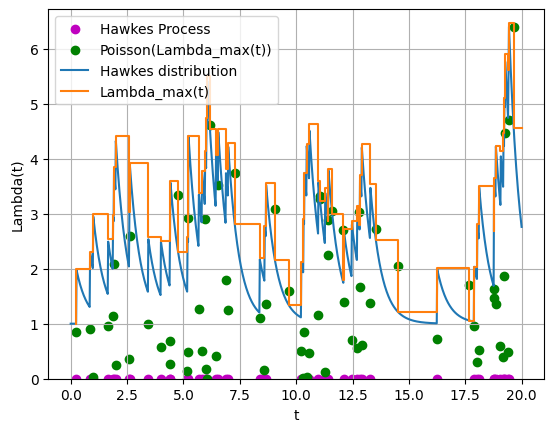

In [6]:
# Show plot
plt.grid(True)
plt.scatter(T, [0]*len(T), color='m', label='Hawkes Process')
plt.scatter(x[:-1], np.array(y), color='g', label='Poisson(Lambda_max(t))')
plt.plot(np.linspace(0, Tmax, 1000), jump_values, label='Hawkes distribution')
plt.ylim(0)
plt.step(x, Lambda_bar, where='pre', label='Lambda_max(t)')
plt.xlabel('t')
plt.ylabel('Lambda(t)')
plt.legend()
plt.grid(True)

# Save the plot as "hawkes_ogata.png"
plt.savefig('hawkes_ogata_int.png')


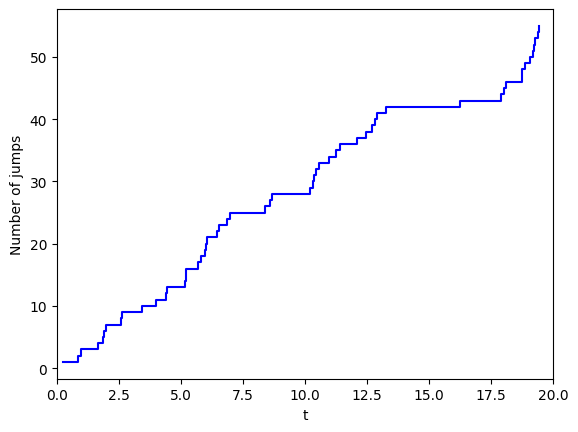

In [7]:
plt.step(T, np.arange(1, len(T) + 1), where='post', color='blue')
plt.xlim(0,Tmax)
plt.xlabel('t')
plt.ylabel('Number of jumps')
plt.savefig('hawkes_ogata.png')


## 2cd method: Superposition of Poisson Processes

Pour que ça fonctionne bien, il faut penser à vectoriser tout ça. Première étape : on tire le nombre d'évènements suivant une loi de Poisson de paramètre Lambda_0, et on répartit uniformément sur l'intervalle voulu. Pour chaque évènement, on va tirer la génération d'après : chaque individus aura un nombre d'enfant selon une lois de poisson de paramètre p (1/2 dans notre cas) sur l'intervalle restant. Chaque individu est ensuite distribué selon une loi exponentielle (qui apparait avec le choix de l'exponentielle négative, sinon distribué selon h/p). On boucle jusqu'à ce qu'il n'y ait plus d'enfants.

In [8]:
# A supprimer pour le code final car surement inutile

def jump(t,Time_jumps,n_jumps, Lambda_i): # Intensité du processus de Hawkes au temps t
    val = Lambda_i
    for j in range(0,n_jumps):
        if (t >= Time_jumps[j]):
            val += np.exp(-2*(t-Time_jumps[j]))
    return(val)

def next_gen(T, jump_values,Lambda_i, Tmax, res): # Simulation des temps d'apparition des enfants pour un parent donné.
    result = []
    if(len(T) == 0):
        return([])
    for i in range(len(T)):
        gen_jump = np.append(T[i], jump_values)
        n_gen = np.random.poisson(1/2*(Tmax - np.max(gen_jump)))
        # time_before_birth = np.random.exponential(1/2,n_gen)
        if n_gen == 0:
            return ([])
        
        times_gen = [val + T[i] for val in np.random.exponential(1/2,n_gen) if val <= Tmax - T[i]]
        
        if n_gen <= 1:
            res = np.append(res, times_gen)
            return(res)

        result.append(next_gen(times_gen, gen_jump, Lambda_i, Tmax, np.append(res, times_gen)))
    return(result)


First generation :

In [9]:
num_immigrant = np.random.poisson(Lambda_init * Tmax)
hawkes = np.sort(np.random.uniform(0, Tmax, num_immigrant))
print("Nombre d'immigrants : " + str(num_immigrant))

Nombre d'immigrants : 21


Following the construction given in article [1] :

In [32]:
OG = np.random.poisson(Lambda_init * Tmax)
hawkes = np.sort(np.random.uniform(0, Tmax, OG))
print("Nombre d'immigrants : " + str(OG))
new_gen = 1
times = hawkes
i = 1
while len(times) != 0:
    # We first get the number of childs for each individual
    num_childs = [np.random.poisson(0.5) for root in times] 
    print("Nombre d'individus de la génération " + str(i) + " : " + str(len(times)))
    # end condition
    if(num_childs == [0]*len(times)):
        break
    
    # We remove individuals without childs
    times = [times[i] for i in range(len(times)) if num_childs[i] > 0]
    num_childs = [num_childs[i] for i in range(len(num_childs)) if num_childs[i] > 0]
    
    # We then create the next generation time vector
    times = [times[j] + np.random.exponential(1/2) for j in range(len(times)) for i in range(num_childs[j])] 
    
    times = [val for val in times if val < Tmax]
    
    # We finally update the Hawkes vector 
    hawkes = np.append(hawkes, times) 
    i = i+1
hawkes = np.sort(hawkes)

Nombre d'immigrants : 18
Nombre d'individus de la génération 1 : 18
Nombre d'individus de la génération 2 : 11
Nombre d'individus de la génération 3 : 6
Nombre d'individus de la génération 4 : 5
Nombre d'individus de la génération 5 : 2
Nombre d'individus de la génération 6 : 1
Nombre d'individus de la génération 7 : 1


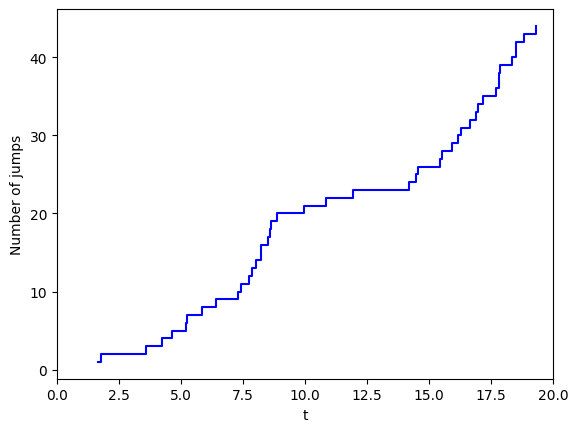

In [33]:
plt.step(hawkes, np.arange(1, len(hawkes) + 1), where='post', color='blue')
plt.xlim(0,Tmax)
plt.xlabel('t')
plt.ylabel('Number of jumps')
plt.savefig('hawkes_second_method.png')